<a href="https://colab.research.google.com/github/Shemonti/Breast-Histology-Images/blob/main/IDC_Image_classification_with_self_attention_50_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import fnmatch
import os
import PIL
import glob
import tensorflow as tf
from matplotlib.image import  imread
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unrar x -Y "/content/drive/MyDrive/data_used (1).rar" 

Streaming output truncated to the last 5000 lines.
Extracting  data_used/IDC/12906_idx5_x1701_y1651_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1701_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1751_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1801_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1851_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1901_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1951_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y2001_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y2151_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y2201_class1.png               35%  OK 
Extracting  data_used/IDC/129

In [4]:
import pathlib
dt_dir='/content/data_used'
data_dir = pathlib.Path(dt_dir)
data_dir

PosixPath('/content/data_used')

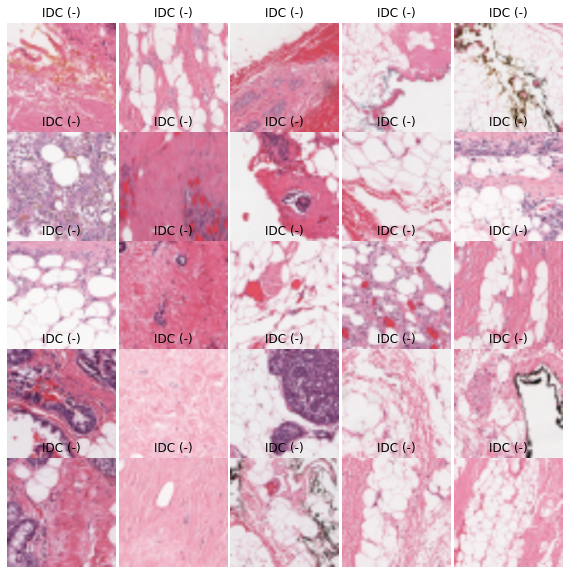

In [5]:
NORMAL=list(data_dir.glob('NORMAL/*.png'))
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for imgname in NORMAL[:25]:
    im = cv2.imread(str(imgname))
    im = cv2.resize(im, (227, 227)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.axis('off')        
    plt.title('IDC (-)')
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB));
     #.set_title(l)
     
    i_ += 1

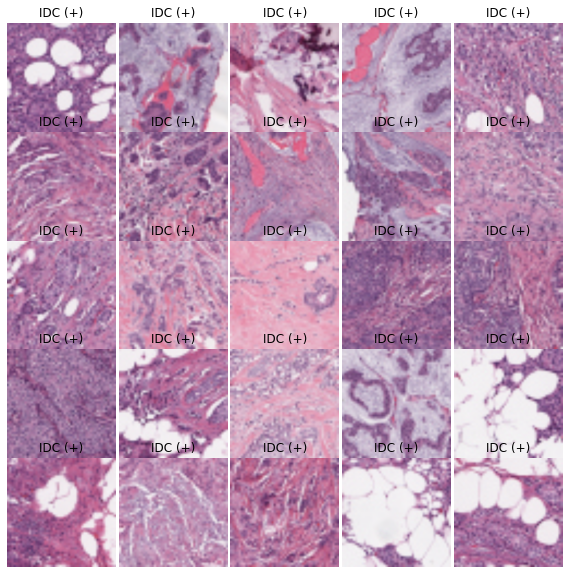

In [6]:
IDC=list(data_dir.glob('IDC/*.png'))
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for imgname in IDC[:25]:
   



    im = cv2.imread(str(imgname))
    im = cv2.resize(im, (227, 227)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.axis('off')        
    plt.title('IDC (+)')
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB));
     #.set_title(l)
     
    i_ += 1

In [7]:
breast_images_dict = {
    'IDC(-)': list(data_dir.glob('NORMAL/*.png')),
    'IDC(+)': list(data_dir.glob('IDC/*.png')),
    
}

In [8]:
breast_labels_dict = {
    'IDC(-)': 0,
    'IDC(+)': 1
   
}

In [9]:
X, y = [], []

for breast_name, images in breast_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        im = cv2.resize(img, (64, 64))
        X.append(im)
        y.append(breast_labels_dict[breast_name])

In [10]:
X = np.array(X)
y = np.array(y)

In [11]:
X.shape

(7500, 64, 64, 3)

In [12]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [13]:
len(y)

7500

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.3, random_state=42)
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_val = to_categorical(y_val)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(5250, 64, 64, 3) (675, 64, 64, 3) (1575, 64, 64, 3) (5250,) (675,) (1575,)


In [16]:
y_val

array([1, 0, 1, ..., 0, 1, 0])

In [17]:
len(X_train)

5250

In [18]:
len(X_test)

675

In [19]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
X_val_scaled = X_val / 255

In [20]:
data_augmentation = keras.Sequential(
  [
   layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(64, 
                                                              64,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

EANet

In [21]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [23]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
image_size = 64  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (im.shape[0] // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [24]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 64 X 64
Patch size: 6 X 6
Patches per image: 100
Elements per patch: 108


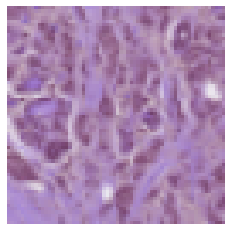

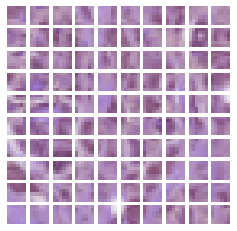

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [26]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [27]:
def create_vit_classifier():
    inputs = layers.Input(shape=im.shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(2)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [28]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Epoch 1/50
165/165 [==============================] - 28s 112ms/step - loss: 1.5666 - accuracy: 0.5560 - val_loss: 0.7207 - val_accuracy: 0.3937
Epoch 2/50
165/165 [==============================] - 13s 80ms/step - loss: 0.5538 - accuracy: 0.7493 - val_loss: 0.5157 - val_accuracy: 0.8178
Epoch 3/50
165/165 [==============================] - 10s 62ms/step - loss: 0.3970 - accuracy: 0.8290 - val_loss: 0.6264 - val_accuracy: 0.7784
Epoch 4/50
165/165 [==============================] - 10s 63ms/step - loss: 0.3681 - accuracy: 0.8491 - val_loss: 0.2649 - val_accuracy: 0.9022
Epoch 5/50
165/165 [==============================] - 10s 62ms/step - loss: 0.3128 - accuracy: 0.8817 - val_loss: 0.3932 - val_accuracy: 0.8584
Epoch 6/50
165/165 [==============================] - 10s 62ms/step - loss: 0.3199 - accuracy: 0.8691 - val_loss: 0.2667 - val_accuracy: 0.9010
Epoch 7/50
165/165 [==============================] - 12s 72ms/step - loss: 0.3093 - accuracy: 0.8710 - val_loss: 0.3860 - val_accuracy

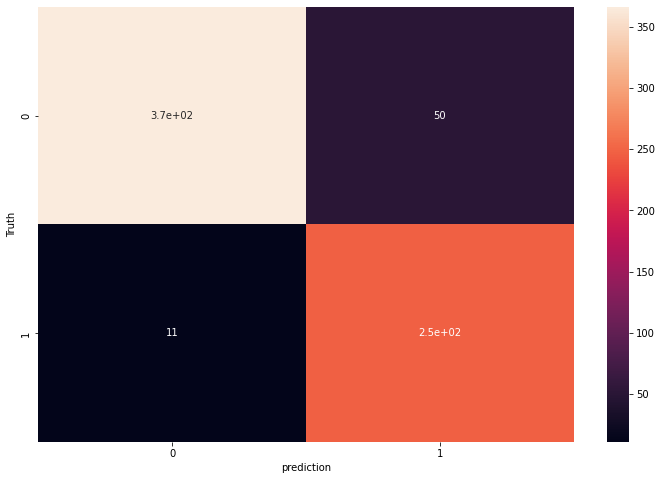

In [29]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    

    history = model.fit(X_train_scaled, y_train, epochs=50,validation_data = (X_val_scaled,y_val))


    _, accuracy, = model.evaluate(X_test_scaled, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    predictions = model.predict(X_test_scaled)
    y_pred = [np.argmax(element) for element in predictions]
    from sklearn.metrics import classification_report,confusion_matrix
    print(classification_report(y_test,y_pred))
    confusion=(confusion_matrix(y_test,y_pred))
    plt.figure(figsize=(12,8))
    sns.heatmap(confusion,annot=True)
    plt.xlabel('prediction')
    plt.ylabel('Truth')
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)